Versión de: https://keras.io/examples/nlp/neural_machine_translation_with_transformer/


1.- Se importaron librerías:

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import tensorflow as tf

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization
import keras.ops as ops

/Users/fau/venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Se descargaron los datos desde:

In [3]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng_extracted"/ "spa-eng" / "spa.txt"

In [4]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [27]:
for _ in range(1):
    print(random.choice(text_pairs))

('Are you still in love with your wife?', '[start] ¿Sigues enamorado de tu esposa? [end]')


In [28]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [29]:
vocab_size = 5000
sequence_length = 25
batch_size = 64

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [135]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds0 = make_dataset(train_pairs)
val_ds0 = make_dataset(val_pairs)

In [136]:
for inputs, targets in train_ds0.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 25)
inputs["decoder_inputs"].shape: (64, 25)
targets.shape: (64, 25)


In [137]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [138]:
embed_dim = 126
latent_dim = 1048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

In [139]:
epochs = 15  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)
history_transformer=transformer.fit(train_ds0, epochs=epochs, validation_data=val_ds0)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 126) │    633,150 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 126) │    633,150 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 126) │    776,956 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 126) │  1,288,390 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ not_equal_3[0][0… │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, None, 126) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, None,      │    635,000 │ dropout_11[0][0]  │
│                     │ 5000)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,966,646 (15.13 MB)

 Trainable params: 3,966,646 (15.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 221s 163ms/step - accuracy: 0.0760 - loss: 4.9541 - val_accuracy: 0.1319 - val_loss: 3.2494
Epoch 2/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 196s 150ms/step - accuracy: 0.1284 - loss: 3.4070 - val_accuracy: 0.1441 - val_loss: 3.0036
Epoch 3/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 203s 156ms/step - accuracy: 0.1356 - loss: 3.2866 - val_accuracy: 0.1432 - val_loss: 3.0998
Epoch 4/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 205s 158ms/step - accuracy: 0.1338 - loss: 3.3680 - val_accuracy: 0.1399 - val_loss: 3.1858
Epoch 5/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 208s 160ms/step - accuracy: 0.1329 - loss: 3.3961 - val_accuracy: 0.1391 - val_loss: 3.2434
Epoch 6/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 210s 161ms/step - accuracy: 0.1320 - loss: 3.4339 - val_accuracy: 0.1376 - val_loss: 3.2453
Epoch 7/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 214s 164ms/step - accuracy: 0.1296 - loss: 3.4931 - val_accuracy: 0.1359 - val_loss: 3.2487
Epoch 8/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 212s 163ms/step - ac

In [140]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 25


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence,":",translated)


The balloon is filled with air. : [start] de de [UNK] [UNK] [UNK] [end]
I'll go in. : [start] [UNK] [UNK] [UNK] [UNK] [UNK] [end]
Copy this, please. : [start] [UNK] [UNK] [UNK] [UNK] [end]
Aim at the target with this gun. : [start] [UNK] [UNK] [UNK] [UNK] [end]
I need to know everything that happened. : [start] [end]


Referencias: https://github.com/tensorflow/text/blob/608b4aa00ccd2b903fcba68f039a829b1ffe104b/docs/tutorials/nmt_with_attention.ipynb

https://keras.io/examples/nlp/pretrained_word_embeddings/

In [5]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

from keras.layers import Embedding


In [6]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [7]:
text_file

PosixPath('/Users/fau/.keras/datasets/spa-eng_extracted/spa-eng/spa.txt')

In [8]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [9]:
context_raw , target_raw  = load_data(text_file)
print(context_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [ ]:
print(target_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


: 

In [10]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

2025-03-21 23:01:13.926759: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-21 23:01:13.926784: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-21 23:01:13.926790: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1742619673.926803  245228 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742619673.926826  245228 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
total_raw=(
    tf.data.Dataset
    .from_tensor_slices((context_raw, target_raw)))

In [12]:
for example_context_strings, example_target_strings in train_raw:
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Tom consumes a lot of wine.' b'We had leftovers for lunch.'
 b"Tom can't swim very well yet."
 b'I came near to getting involved in a crime.'
 b'Tom was looking for Mary.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Tom consume mucho vino.' b'Tuvimos los sobrantes para el almuerzo.'
 b'Tom a\xc3\xban no puede nadar muy bien.'
 b'Casi me vi involucrado en un crimen.' b'Tom buscaba a Mar\xc3\xada.'], shape=(5,), dtype=string)


In [13]:
print(len(context_raw))
print(len(target_raw))

118964
118964


In [14]:
context_raw_tensor=tf.constant(context_raw)
target_raw_tensor=tf.constant(context_raw)

In [15]:
example_context_strings[-1]

<tf.Tensor: shape=(), dtype=string, numpy=b'The ticket is valid for a week.'>

In [16]:
example_text = tf.constant('¿Cómo estas?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfC\xc3\xb3mo estas?'
b'\xc2\xbfCo\xcc\x81mo estas?'


In [17]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text
     

In [18]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Cómo estas?
[START] ¿ como estas ? [END]


In [19]:
max_vocab_size = 10000
sequence_length=25

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    output_sequence_length=sequence_length,
    ragged=True)

In [20]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

2025-03-21 23:02:15.528517: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom')]

In [ ]:
#No es necesario correr sobre todo el DS, tarda 10 minutos

#context_text_processor = tf.keras.layers.TextVectorization(
#    standardize=tf_lower_and_split_punct,
#    max_tokens=max_vocab_size,
#    output_sequence_length=sequence_length,
#    ragged=True)

#context_text_processor.adapt(total_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

2025-03-21 18:43:45.350188: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom')]

In [21]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    output_sequence_length=sequence_length,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

2025-03-21 23:03:40.576771: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('que'),
 np.str_('de'),
 np.str_('el'),
 np.str_('a'),
 np.str_('no')]

In [ ]:
#No es necesario correr sobre todo el DS, tarda 10 minutos

#target_text_processor = tf.keras.layers.TextVectorization(
#    standardize=tf_lower_and_split_punct,
#    max_tokens=max_vocab_size,
#    output_sequence_length=sequence_length,
#    ragged=True)

#target_text_processor.adapt(total_raw.map(lambda context, target: target))
#target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('que'),
 np.str_('de'),
 np.str_('el'),
 np.str_('a'),
 np.str_('no')]

In [67]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 66, 57, 8, 80, 118, 71, 170, 11, 3],
 [2, 26, 148, 24, 88, 58, 250, 4, 3], [2, 149, 30, 213, 28, 25, 4, 3]]>

In [68]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] when did you come back from boston ? [END]'

Text(0.5, 1.0, 'Mask inglés')

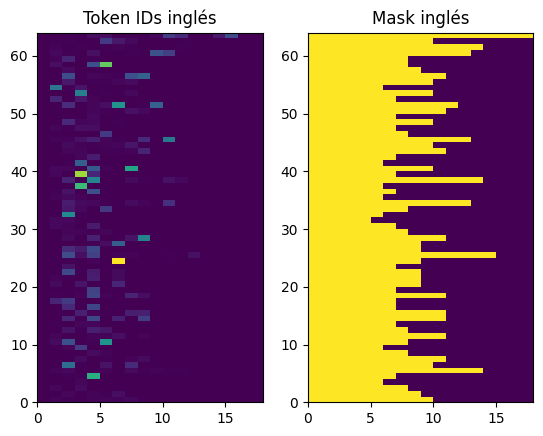

In [69]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs inglés')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask inglés')

Text(0.5, 1.0, 'Mask')

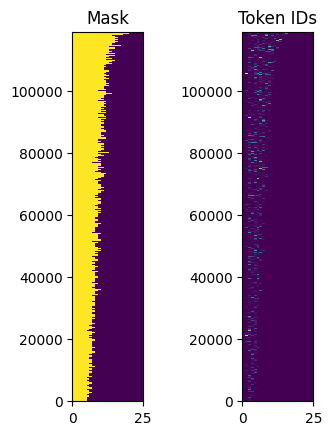

In [121]:
example_tokens = context_text_processor(context_raw_tensor)

plt.subplot(1, 6, 3)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 6, 1)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')


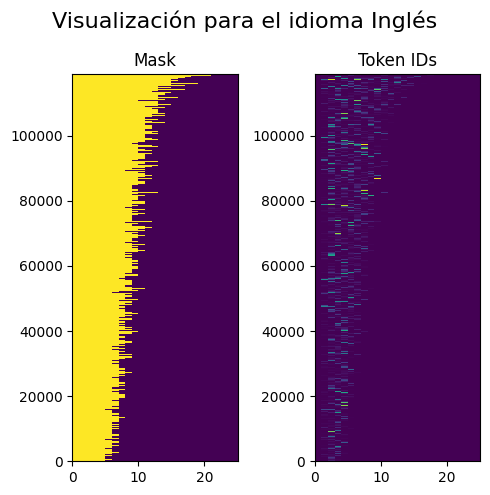

In [141]:
# Suponiendo que 'context_raw_tensor' es tu tensor de entrada
example_tokens = context_text_processor(context_raw_tensor)

# Crear la figura y subgráficos
fig, axs = plt.subplots(1, 2, figsize=(5, 5))  # 1 fila, 6 columnas

# Mostrar el gráfico de los token IDs (columna 3)
axs[1].pcolormesh(example_tokens.to_tensor())
axs[1].set_title('Token IDs')

# Mostrar la máscara (columna 1)
axs[0].pcolormesh(example_tokens.to_tensor() != 0)
axs[0].set_title('Mask')

# Título global de la figura
fig.suptitle("Visualización para el idioma Inglés", fontsize=16)

# Ajuste automático de márgenes para que no se solapen
fig.tight_layout()

# Mostrar el gráfico
plt.show()


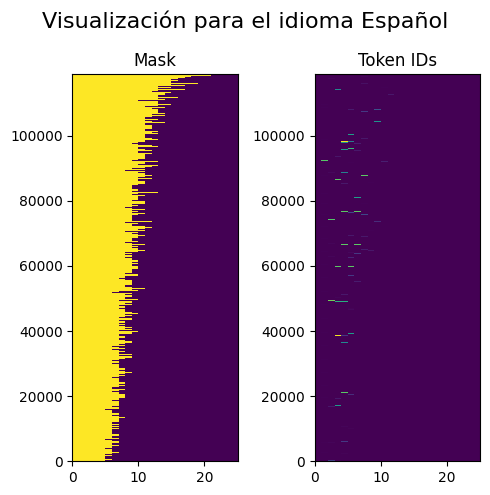

In [142]:
# Suponiendo que 'context_raw_tensor' es tu tensor de entrada
example_tokens = target_text_processor(target_raw_tensor)

# Crear la figura y subgráficos
fig, axs = plt.subplots(1, 2, figsize=(5, 5))  # 1 fila, 6 columnas

# Mostrar el gráfico de los token IDs (columna 3)
axs[1].pcolormesh(example_tokens.to_tensor())
axs[1].set_title('Token IDs')

# Mostrar la máscara (columna 1)
axs[0].pcolormesh(example_tokens.to_tensor() != 0)
axs[0].set_title('Mask')

# Título global de la figura
fig.suptitle("Visualización para el idioma Español", fontsize=16)

# Ajuste automático de márgenes para que no se solapen
fig.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:

def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

: 

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2   5 707  12 507  15 254   4   3   0]

[  2   6 773  20 684   7 210   4   0   0]
[  6 773  20 684   7 210   4   3   0   0]


2025-03-19 23:07:42.408357: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


: 

Embbeding

In [143]:
vectorizer_content=context_text_processor.get_vocabulary()
word_index_content=dict(zip(vectorizer_content, range(len(vectorizer_content))))

vectorizer_target=target_text_processor.get_vocabulary()
word_index_target=dict(zip(vectorizer_target, range(len(vectorizer_target))))

voc=vectorizer_target
word_index=word_index_target

In [144]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [145]:
num_tokens = max_vocab_size
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4349 words (5651 misses)


In [ ]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])


: 

Modelo

In [ ]:
UNITS = 256

class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)


    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context
     

: 

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 256)


: 

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x
     

: 

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')
     

Context sequence, shape (batch, s, units): (64, 16, 256)
Target sequence, shape (batch, t, units): (64, 15, 256)
Attention result, shape (batch, t, units): (64, 15, 256)
Attention weights, shape (batch, t, s):    (64, 15, 16)


: 

In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)


array([1.       , 1.0000001, 1.       , 1.       , 1.       , 1.       ,
       1.0000001, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       ], dtype=float32)

: 

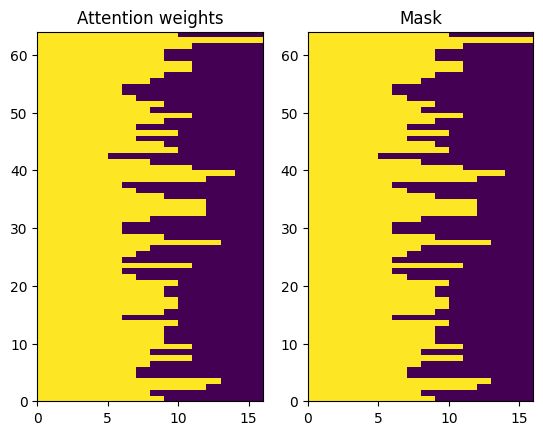

: 

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)
     

: 

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(output, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits
     

: 

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits
     

: 

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

: 

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 16, 256)
input target tokens shape: (batch, t) (64, 15)
logits shape shape: (batch, target_vocabulary_size) (64, 15, 10000)


/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


: 

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  
  # Crear un estado inicial vacío (ceros) que sea compatible con el tamaño de las unidades del RNN.
  state = tf.zeros([batch_size, self.units], dtype=tf.float32)
  
  return start_tokens, done, state


: 

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ * START *', '')
  result = tf.strings.regex_replace(result, ' * END * $', '')
  return result

: 

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

: 

In [ ]:

# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'coro ceremonia palabras latin llegaste incluyen castigo acuerdes interes te',
       b'suministraron posiblemente lees prestamo mueras relampago senor traed almorzamos arrestaron',
       b'comiendo preocupe noventa acercan entraron entristecio docena heladera tierra camarera'],
      dtype=object)

: 

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits
     

: 

In [ ]:
class Translator2(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    self.embedding_layer = Embedding(
          num_tokens, 
          embedding_dim, 
          trainable=False  # Si no deseas que la capa de embedding se entrene
    )
    self.embedding_layer.build((1,))
    self.embedding_layer.set_weights([embedding_matrix])  # Asignamos los pesos a la capa

    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)
    self.encoder = encoder
    self.decoder = decoder


  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits
     

: 

In [ ]:
#@title
def add_translate_method(class_type):
    @class_type.add_method
    def translate(self,
                  texts, *,
                  max_length=50,
                  temperature=0.0):
      # Process the input texts
      context = self.encoder.convert_input(texts)
      batch_size = tf.shape(texts)[0]

      # Setup the loop inputs
      tokens = []
      attention_weights = []
      next_token, done, state = self.decoder.get_initial_state(context)

      for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)
            
        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)
        
        if tf.executing_eagerly() and tf.reduce_all(done):
          break

      # Stack the lists of tokens and attention weights.
      tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
      self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

      result = self.decoder.tokens_to_text(tokens)
      return result

# Añadir la función a Translator1 y Translator2
add_translate_method(Translator)
add_translate_method(Translator2)

: 

In [ ]:
def add_plot_attention_method(class_type):
    @class_type.add_method
    def plot_attention(self, text, **kwargs):
        assert isinstance(text, str)
        output = self.translate([text], **kwargs)
        output = output[0].numpy().decode()

        attention = self.last_attention_weights[0]

        context = tf_lower_and_split_punct(text)
        context = context.numpy().decode().split()

        output = tf_lower_and_split_punct(output)
        output = output.numpy().decode().split()[1:]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)

        ax.matshow(attention, cmap='viridis', vmin=0.0)

        fontdict = {'fontsize': 14}

        ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + output, fontdict=fontdict)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        ax.set_xlabel('Input text')
        ax.set_ylabel('Output text')

# Añadir la función a Translator1 y Translator2
add_plot_attention_method(Translator)
add_plot_attention_method(Translator2)


: 

In [ ]:
model0 = Translator(UNITS, context_text_processor, target_text_processor)

logits = model0((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_3' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Context tokens, shape: (batch, s, units) (64, 16)
Target tokens, shape: (batch, t) (64, 15)
logits, shape: (batch, t, target_vocabulary_size) (64, 15, 10000)


/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


: 

In [ ]:
model = Translator2(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 16)
Target tokens, shape: (batch, t) (64, 15)
logits, shape: (batch, t, target_vocabulary_size) (64, 15, 10000)


/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'decoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking an

: 

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

: 

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

: 

In [ ]:
model0.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])
     

: 

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

: 

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': np.float32(9.2103405), 'expected_acc': 0.0001}

: 

In [ ]:
model0.evaluate(val_ds, steps=20, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 9.2315 - masked_acc: 0.0000e+00 - masked_loss: 9.2315


{'loss': 9.23009204864502, 'masked_acc': 0.0, 'masked_loss': 9.23009204864502}

: 

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 9.2180 - masked_acc: 0.0000e+00 - masked_loss: 9.2180


{'loss': 9.218774795532227,
 'masked_acc': 0.0,
 'masked_loss': 9.218774795532227}

: 

In [ ]:
model0.summary()

Model: "translator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_9 (Encoder)             │ ?                      │     4,349,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │     5,788,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,137,936 (38.67 MB)

 Trainable params: 9,137,936 (34.86 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

: 

In [ ]:
model.summary()

Model: "translator2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (1, 100)               │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_10 (Encoder)            │ ?                      │     4,349,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │     5,788,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137,936 (42.49 MB)

 Trainable params: 9,137,936 (34.86 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

: 

In [ ]:
history0 = model0.fit(
    train_ds.repeat(), 
    epochs=30,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 339ms/step - loss: 6.3353 - masked_acc: 0.1880 - masked_loss: 6.3353 - val_loss: 4.4531 - val_masked_acc: 0.3439 - val_masked_loss: 4.4531
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 297ms/step - loss: 4.3178 - masked_acc: 0.3588 - masked_loss: 4.3178 - val_loss: 3.7309 - val_masked_acc: 0.4124 - val_masked_loss: 3.7309
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 291ms/step - loss: 3.6745 - masked_acc: 0.4282 - masked_loss: 3.6745 - val_loss: 3.2214 - val_masked_acc: 0.4825 - val_masked_loss: 3.2214
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - loss: 3.1663 - masked_acc: 0.4868 - masked_loss: 3.1663 - val_loss: 2.8188 - val_masked_acc: 0.5248 - val_masked_loss: 2.8188
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - loss: 2.8490 - masked_acc: 0.5321 - masked_loss: 2.8490 - val_loss: 2.4877 - val_masked_acc: 0.5747 - val_masked_loss: 2.4877
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 288ms/step - loss: 2.5357 - masked_acc: 0

: 

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=30,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/30


/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 402ms/step - loss: 6.3289 - masked_acc: 0.2013 - masked_loss: 6.3289 - val_loss: 4.4291 - val_masked_acc: 0.3438 - val_masked_loss: 4.4291
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 339ms/step - loss: 4.2948 - masked_acc: 0.3577 - masked_loss: 4.2948 - val_loss: 3.7062 - val_masked_acc: 0.4202 - val_masked_loss: 3.7062
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 330ms/step - loss: 3.6670 - masked_acc: 0.4270 - masked_loss: 3.6670 - val_loss: 3.2514 - val_masked_acc: 0.4776 - val_masked_loss: 3.2514
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 335ms/step - loss: 3.1900 - masked_acc: 0.4888 - masked_loss: 3.1900 - val_loss: 2.9034 - val_masked_acc: 0.5190 - val_masked_loss: 2.9034
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 319ms/step - loss: 2.8383 - masked_acc: 0.5336 - masked_loss: 2.8383 - val_loss: 2.5874 - val_masked_acc: 0.5628 - val_masked_loss: 2.5874
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 319ms/step - loss: 2.5861 - masked_acc: 0.5674 - mas

: 

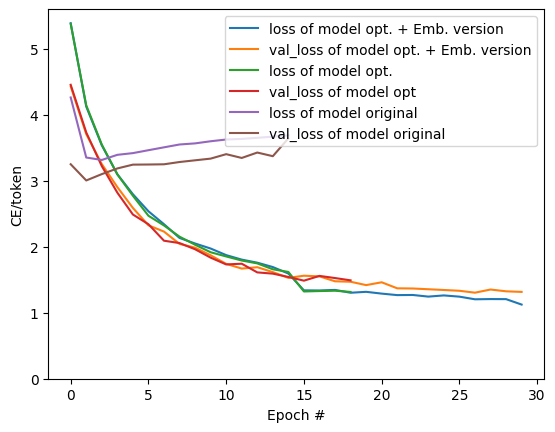

In [141]:
plt.plot(history.history['loss'], label='loss of model opt. + Emb. version')
plt.plot(history.history['val_loss'], label='val_loss of model opt. + Emb. version')
plt.plot(history0.history['loss'], label='loss of model opt.')
plt.plot(history0.history['val_loss'], label='val_loss of model opt')
plt.plot(history_transformer.history['loss'], label='loss of model original')
plt.plot(history_transformer.history['val_loss'], label='val_loss of model original')

#history_transformer
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

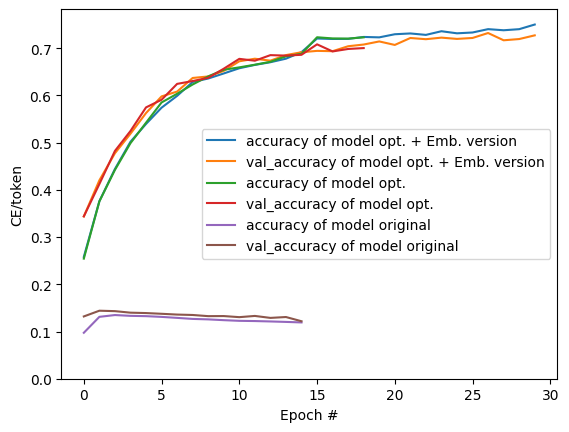

In [142]:
plt.plot(history.history['masked_acc'], label='accuracy of model opt. + Emb. version')
plt.plot(history.history['val_masked_acc'], label='val_accuracy of model opt. + Emb. version')
plt.plot(history0.history['masked_acc'], label='accuracy of model opt.')
plt.plot(history0.history['val_masked_acc'], label='val_accuracy of model opt.')
plt.plot(history_transformer.history['accuracy'], label='accuracy of model original')
plt.plot(history_transformer.history['val_accuracy'], label='val_accuracy of model original')

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
result = model.translate(['Are  you there?']) # Are you still home
result[0].numpy().decode()

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


'¿ estais ahi ? '

: 

/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


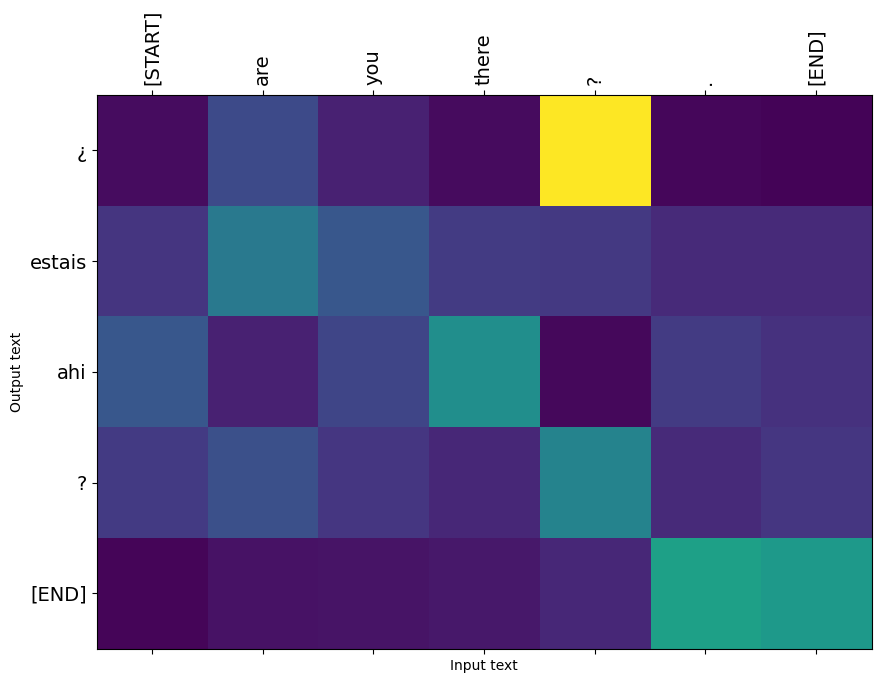

: 

In [ ]:
model.plot_attention('Are you there?.') # Are you still home

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


CPU times: user 429 ms, sys: 99.3 ms, total: 528 ms
Wall time: 599 ms


/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


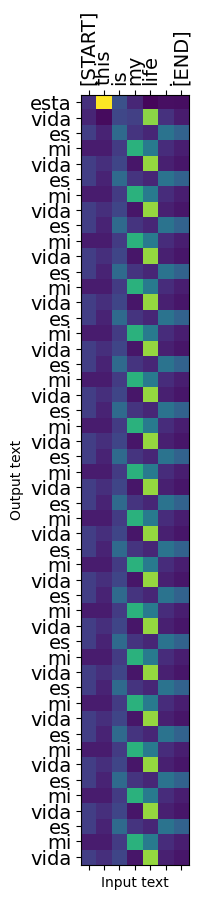

: 

In [ ]:
%%time
# This is my life.
model.plot_attention('This is my life.')

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


CPU times: user 411 ms, sys: 105 ms, total: 516 ms
Wall time: 591 ms


/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


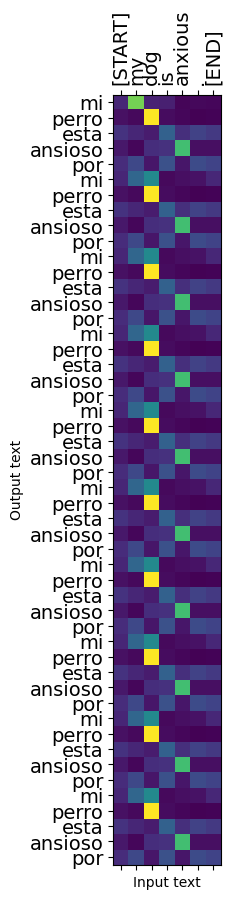

In [143]:
%%time
# This is my life.
model.plot_attention('My dog is anxious.')

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


CPU times: user 413 ms, sys: 105 ms, total: 518 ms
Wall time: 604 ms


/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


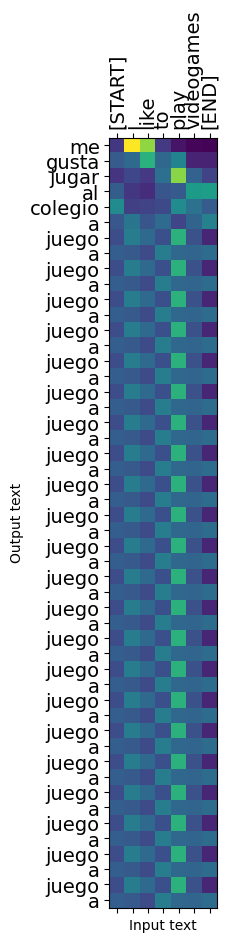

In [144]:
%%time
# This is my life.
model.plot_attention('I like to play videogames')

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


CPU times: user 431 ms, sys: 103 ms, total: 534 ms
Wall time: 640 ms


/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


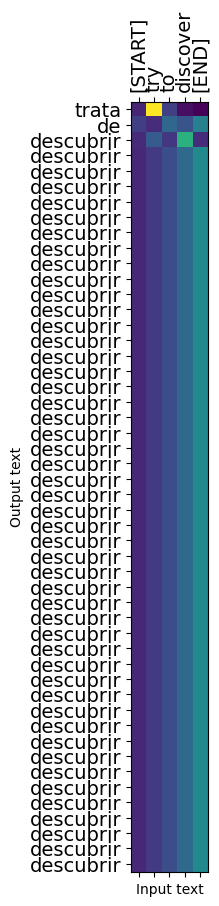

: 

In [ ]:
%%time
 # Try to find out.'
model.plot_attention('Try to discover')

In [ ]:

long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 Si quieres sonar como un hablante nativo, debes estar dispuesto a
practicar diciendo la misma frase una y otra vez de la misma manera en
que un músico de banjo practica el mismo fraseo una y otra vez hasta
que lo puedan tocar correctamente y en el tiempo esperado.


: 

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn/T/ipykernel_4858/1165632988.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/43/scqskd_12mq8v3658vfwf39c0000gn

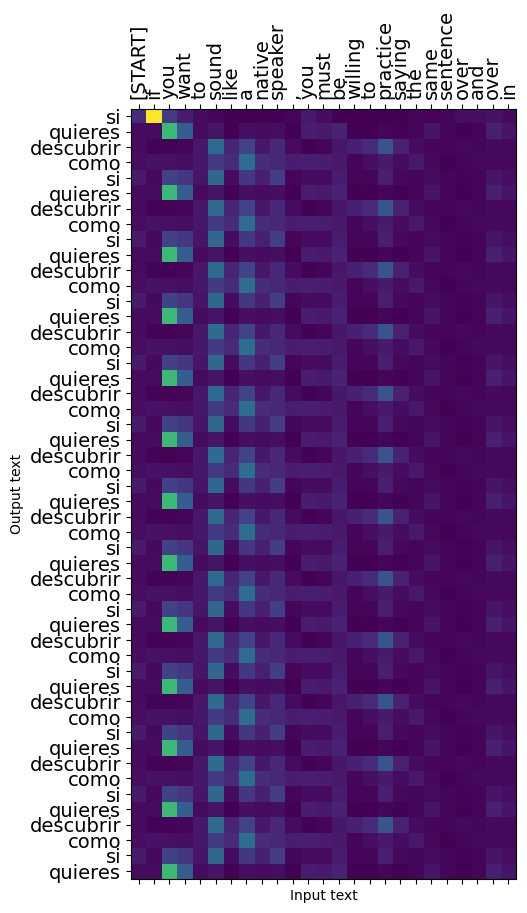

: 

In [ ]:
model.plot_attention(long_text)


In [ ]:
inputs = [
    'Is so could here.', # "It's really cold here."
    'My life is good.', # "This is my life."
    'Your room is a messe.' # "His room is a mess"
]

: 

In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'cross_attention_4' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/fau/venv-metal/lib/python3.9/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_2' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


es tan pesado . 
mi vida es bueno . 
tu habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion

CPU times: user 569 ms, sys: 140 ms, total: 709 ms
Wall time: 812 ms


: 

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

es tan amable .                                              
mi vida es bueno .                                             
tu habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion

CPU times: user 410 ms, sys: 95.4 ms, total: 505 ms
Wall time: 574 ms


: 

In [124]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [125]:
export = Export(model)

In [22]:
%%time
tf.saved_model.save(export, 'translator_dos',
                    signatures={'serving_default': export.translate})

NameError: name 'export' is not defined

In [ ]:
export = Export(model0)
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [28]:
%%time
reloaded = tf.saved_model.load('translator')

CPU times: user 5.5 s, sys: 459 ms, total: 5.96 s
Wall time: 6.15 s


In [128]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

W0000 00:00:1742450436.733131  366112 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


es asi .                                               
mi vida es buena .                                             
tu habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion es una habitacion

CPU times: user 14.7 s, sys: 1.02 s, total: 15.7 s
Wall time: 15.2 s


In [29]:
context=[]
target=[]
for context1, target1 in val_raw:
    context.append(context1)
    target.append(target1)


reference_sentences=[]
translated_sentences=[]

for i in range(0,30):
    input_sentence = context[0][i].numpy().decode('utf-8')
    #print(input_sentence)
    translated_sentence=reloaded.translate([context[0][i].numpy().decode('utf-8')]).numpy()[0].decode('utf-8')
    translated_sentence=(
        translated_sentence.replace("[START]","")
        .replace("[UNK]","")
        .replace("[END]",""))
    #print(type(translated_sentence))
    reference_sentences.append(target[0][i].numpy().decode('utf-8'))
    #print(type(target[0][i].numpy().decode('utf-8')))
    #print(target[0][i].numpy().decode('utf-8'))
    translated_sentences.append(translated_sentence)
    #print(translated_sentence)

import keras_nlp
rouge= keras_nlp.metrics.RougeN(order=1)
rouge2= keras_nlp.metrics.RougeN(order=2)
blue= keras_nlp.metrics.Bleu(max_order=1)
blue2= keras_nlp.metrics.Bleu(max_order=2)
print("Blue score, order 1 = ",blue(reference_sentences, translated_sentence))
print("Blue score, order 2 = ",blue2(reference_sentences, translated_sentence))
print("Rouge score, order 1 = ",rouge(reference_sentences, translated_sentences))
print("Rouge score, order 2 = ",rouge2(reference_sentences, translated_sentences))

W0000 00:00:1742620018.711056  245228 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Blue score, order 1 =  <Variable path=bleu/bleu, shape=(), dtype=float32, value=1.0>
Blue score, order 2 =  <Variable path=bleu/bleu, shape=(), dtype=float32, value=0.8660253882408142>
Rouge score, order 1 =  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.11719340831041336>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3686002492904663>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.14995254576206207>}
Rouge score, order 2 =  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07921671867370605>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19727984070777893>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.09297626465559006>}


In [32]:
reloaded_dos = tf.saved_model.load('translator_dos')

reference_sentences=[]
translated_sentences=[]

for i in range(0,30):
    input_sentence = context[0][i].numpy().decode('utf-8')
    #print(input_sentence)
    translated_sentence=reloaded_dos.translate([context[0][i].numpy().decode('utf-8')]).numpy()[0].decode('utf-8')
    translated_sentence=(
        translated_sentence.replace("[START]","")
        .replace("[UNK]","")
        .replace("[END]",""))
    #print(type(translated_sentence))
    reference_sentences.append(target[0][i].numpy().decode('utf-8'))
    #print(type(target[0][i].numpy().decode('utf-8')))
    #print(target[0][i].numpy().decode('utf-8'))
    translated_sentences.append(translated_sentence)
    #print(translated_sentence)

import keras_nlp
rouge= keras_nlp.metrics.RougeN(order=1)
rouge2= keras_nlp.metrics.RougeN(order=2)
blue= keras_nlp.metrics.Bleu(max_order=1)
blue2= keras_nlp.metrics.Bleu(max_order=2)
print("Blue score, order 1 = ",blue(reference_sentences, translated_sentence))
print("Blue score, order 2 = ",blue2(reference_sentences, translated_sentence))
print("Rouge score, order 1 = ",rouge(reference_sentences, translated_sentences))
print("Rouge score, order 2 = ",rouge2(reference_sentences, translated_sentences))

W0000 00:00:1742620592.281733  245228 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Blue score, order 1 =  <Variable path=bleu/bleu, shape=(), dtype=float32, value=1.0>
Blue score, order 2 =  <Variable path=bleu/bleu, shape=(), dtype=float32, value=0.8660253882408142>
Rouge score, order 1 =  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.25690606236457825>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.37042564153671265>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.22081413865089417>}
Rouge score, order 2 =  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.11192857474088669>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.17976431548595428>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.09806135296821594>}


In [33]:
reloaded_tres = tf.saved_model.load('translator_tres')

context=[]
target=[]
for context1, target1 in val_raw:
    context.append(context1)
    target.append(target1)


reference_sentences=[]
translated_sentences=[]

for i in range(0,30):
    input_sentence = context[0][i].numpy().decode('utf-8')
    #print(input_sentence)
    translated_sentence=reloaded_tres.translate([context[0][i].numpy().decode('utf-8')]).numpy()[0].decode('utf-8')
    translated_sentence=(
        translated_sentence.replace("[START]","")
        .replace("[UNK]","")
        .replace("[END]",""))
    #print(type(translated_sentence))
    reference_sentences.append(target[0][i].numpy().decode('utf-8'))
    #print(type(target[0][i].numpy().decode('utf-8')))
    #print(target[0][i].numpy().decode('utf-8'))
    translated_sentences.append(translated_sentence)
    #print(translated_sentence)

import keras_nlp
rouge= keras_nlp.metrics.RougeN(order=1)
rouge2= keras_nlp.metrics.RougeN(order=2)
blue= keras_nlp.metrics.Bleu(max_order=1)
blue2= keras_nlp.metrics.Bleu(max_order=2)
print("Blue score, order 1 = ",blue(reference_sentences, translated_sentence))
print("Blue score, order 2 = ",blue2(reference_sentences, translated_sentence))
print("Rouge score, order 1 = ",rouge(reference_sentences, translated_sentences))
print("Rouge score, order 2 = ",rouge2(reference_sentences, translated_sentences))

W0000 00:00:1742620771.295173  245228 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Blue score, order 1 =  <Variable path=bleu/bleu, shape=(), dtype=float32, value=0.03999999910593033>
Blue score, order 2 =  <Variable path=bleu/bleu, shape=(), dtype=float32, value=0.0>
Rouge score, order 1 =  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.14561107754707336>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.39037516713142395>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1519012600183487>}
Rouge score, order 2 =  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.06747595220804214>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20297980308532715>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.07742337882518768>}
